In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from viz import raster_evidence_geomap
from features import lat_lng2dist_ang
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az
sns.set_theme()

GEOLOCATION="unil"
TRANSFORMED_CSV = f"datasets/processed/{GEOLOCATION}/transformed.csv"
GT_POINTS_CSV = f"datasets/raw/{GEOLOCATION}/gt_points.csv"
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = 'bivariate_normal.stan'

set_cmdstan_path(CMDSTAN_PATH)


transformed_df = pd.read_csv(TRANSFORMED_CSV)
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
transformed_df["plot_label"] = transformed_df["measured_from"] + " (measured)"
proposal_names = gt_points_df["name"].tolist()
proposal_names.remove("E")
proposal_names

# TODO: consider precise

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['P1', 'P2']

<Axes: xlabel='lng', ylabel='lat'>

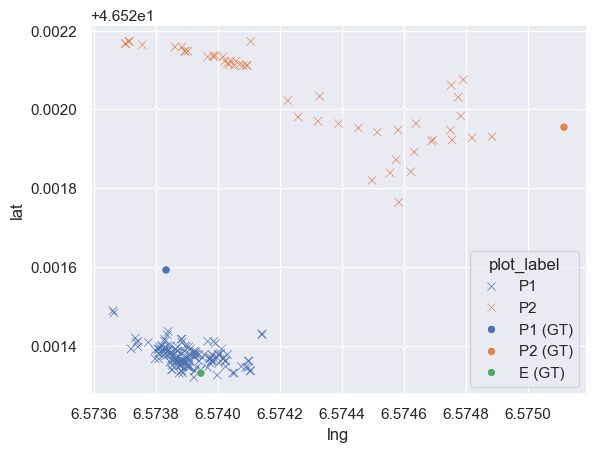

In [2]:
# visualize

fig, ax = plt.subplots()
sns.scatterplot(data=transformed_df, x='lng', y='lat', hue='measured_from', ax=ax, marker='x')
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
sns.scatterplot(data=gt_points_df, x='lng', y='lat', hue='plot_label', ax=ax)

In [3]:
gt_points_df

,name,lat,lng,plot_label
0,P1,46.521592,6.573832,P1 (GT)
1,P2,46.521955,6.575116,P2 (GT)
2,E,46.521331,6.573944,E (GT)


In [4]:
transformed_df

,measured_from,lat,lng,distance,angle_rad,angle_deg,plot_label
0,P1,46.521344,6.573931,28.567320,2.873785,164.655746,P1 (measured)
1,P1,46.521408,6.573775,20.910190,3.352463,192.082006,P1 (measured)
2,P1,46.521381,6.573844,23.554072,3.101168,177.683850,P1 (measured)
3,P1,46.521361,6.573889,26.063941,2.973435,170.365252,P1 (measured)
4,P1,46.521386,6.573825,22.923629,3.165157,181.350112,P1 (measured)
...,...,...,...,...,...,...,...
195,P2,46.521892,6.574633,37.719201,4.525284,259.279701,P2 (measured)
196,P2,46.521919,6.574689,33.032434,4.593177,263.169673,P2 (measured)
197,P2,46.521922,6.574756,27.918201,4.582366,262.550258,P2 (measured)
198,P2,46.521928,6.574819,22.977217,4.581353,262.492195,P2 (measured)


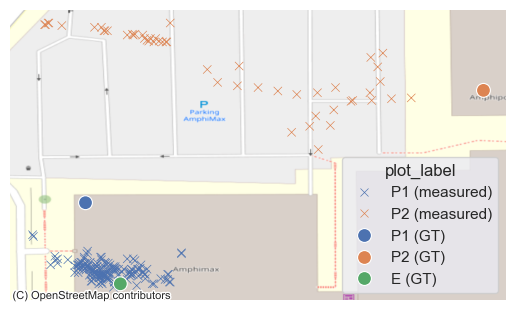

In [5]:
ax = raster_evidence_geomap(gt_points_df, transformed_df)

In [6]:


P1_lat, P1_lng = gt_points_df[gt_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist()
P2_lat, P2_lng = gt_points_df[gt_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist()
E_lat, E_lng = gt_points_df[gt_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
E_P1_dist, E_P1_angle_rad, E_P1_angle_deg = lat_lng2dist_ang([P1_lat, P1_lng], [E_lat, E_lng])
E_P2_dist, E_P2_angle_rad, E_P2_angle_deg = lat_lng2dist_ang([P2_lat, P2_lng], [E_lat, E_lng])

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"E: {E_lat}, {E_lng}")
print(f"E using P1 as the center: dist={E_P1_dist}, angle_rad={E_P1_angle_rad}, angle_deg={E_P1_angle_deg}")
print(f"E using P2 as the center: dist={E_P2_dist}, angle_rad={E_P2_angle_rad}, angle_deg={E_P2_angle_deg}")


P1: 46.521592273, 6.573832039
P2: 46.521954786, 6.575116326
E: 46.521330555, 6.573944444
E using P1 as the center: dist=30.344572744546294, angle_rad=2.8533795973322875, angle_deg=163.48660827587835
E using P2 as the center: dist=113.5817863518005, angle_rad=4.055162326777971, angle_deg=232.34368656482852


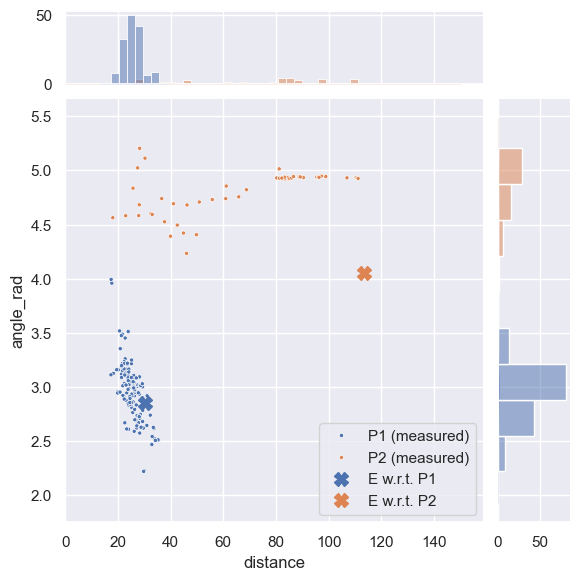

In [7]:
#! P1(measured) and P2(measured) are measurements that are transformed to dist and angle WITH RESPECT TO THEIR GROUND TRUTH (P1 or P2)
g = sns.jointplot(
        data=transformed_df,
        x="distance",
        y="angle_rad",
        hue="plot_label",
        kind="scatter",
        marginal_ticks=True,
        joint_kws={"marker": "."},
        # alpha=0.5
    )

# lower bound for distance is 0
g.ax_joint.set_xlim(left=0)
g.plot_marginals(sns.histplot)


for proposal_name in proposal_names:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][["lat", "lng"]].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    g.ax_joint.plot(dist, angle_rad, 'X', label=f"E w.r.t. {proposal_name}", markersize=10)
g.ax_joint.legend()

In [8]:
def visualize_polar(measurements_df, gt_points_df):
    fig, ax = plt.subplots(1, gt_points_df.shape[0] - 1, subplot_kw=dict(polar=True))
    # meters and degrees
    for i, row in gt_points_df.iterrows():
        if row["name"] == "E":
            continue
        proposal_name = row["name"]
        proposal_data = measurements_df[measurements_df["measured_from"] == proposal_name]
        ax[i].scatter(proposal_data["angle_rad"], proposal_data["dist"], label=proposal_name)
        ax[i].set_title(proposal_name)
        ax[i].set_ylim(0, 100)
        ax[i].set_yticks([0, 25, 50, 75, 100])

    return ax

# visualize_polar(measurements_df, gt_points_df) # TODO: improve this for the paper

In [9]:
transformed_df

,measured_from,lat,lng,distance,angle_rad,angle_deg,plot_label
0,P1,46.521344,6.573931,28.567320,2.873785,164.655746,P1 (measured)
1,P1,46.521408,6.573775,20.910190,3.352463,192.082006,P1 (measured)
2,P1,46.521381,6.573844,23.554072,3.101168,177.683850,P1 (measured)
3,P1,46.521361,6.573889,26.063941,2.973435,170.365252,P1 (measured)
4,P1,46.521386,6.573825,22.923629,3.165157,181.350112,P1 (measured)
...,...,...,...,...,...,...,...
195,P2,46.521892,6.574633,37.719201,4.525284,259.279701,P2 (measured)
196,P2,46.521919,6.574689,33.032434,4.593177,263.169673,P2 (measured)
197,P2,46.521922,6.574756,27.918201,4.582366,262.550258,P2 (measured)
198,P2,46.521928,6.574819,22.977217,4.581353,262.492195,P2 (measured)


In [10]:
stan_data = {
    "N1": transformed_df[transformed_df["measured_from"] == "P1"].shape[0],
    "N2": transformed_df[transformed_df["measured_from"] == "P2"].shape[0],
    "y1": transformed_df[transformed_df["measured_from"] == "P1"][["distance", "angle_rad"]].values.tolist(),
    "y2": transformed_df[transformed_df["measured_from"] == "P2"][["distance", "angle_rad"]].values.tolist(),
    "E_p1": [E_P1_dist, E_P1_angle_rad],
    "E_p2": [E_P2_dist, E_P2_angle_rad]
}





model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = model.sample(data=stan_data,
                        chains=4,
                        iter_warmup=1000,
                        iter_sampling=4000,
                        seed=1,
                        parallel_chains=os.cpu_count()
)

display(fit.summary())
print(fit.diagnose())

12:43:07 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
12:43:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Iteration:    1 / 5000 [  0%]  (Warmup)


chain 1 |▉         | 00:00 Iteration:  300 / 5000 [  6%]  (Warmup)


chain 1 |█▋        | 00:00 Iteration:  700 / 5000 [ 14%]  (Warmup)


chain 1 |██▌       | 00:00 Iteration: 1001 / 5000 [ 20%]  (Sampling)


chain 1 |███       | 00:00 Iteration: 1300 / 5000 [ 26%]  (Sampling)




chain 1 |███▋      | 00:01 Iteration: 1600 / 5000 [ 32%]  (Sampling)


chain 1 |████      | 00:01 Iteration: 1800 / 5000 [ 36%]  (Sampling)




chain 1 |████▍     | 00:01 Iteration: 2000 / 5000 [ 40%]  (Sampling)



chain 1 |████▊     | 00:01 Iteration: 2200 / 5000 [ 44%]  (Sampling)


chain 1 |█████▏    | 00:01 Iteration: 2400 / 5000 [ 48%]  (Sampling)


chain 1 |█████▌    | 00:02 Iteration: 2600 / 5000 [ 52%]  (Sampling)


chain 1 |█████▉ 


12:43:12 - cmdstanpy - INFO - CmdStan done processing.
12:43:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 25, column 2 to column 34)
	Exception: lkj

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-228.29900,0.027063,2.268050,-232.46400,-227.95600,-225.21800,7023.31,525.107,1.000710
mu1[1],25.71580,0.002581,0.292180,25.23690,25.71750,26.19630,12818.10,958.363,0.999766
mu1[2],2.94593,0.000189,0.021810,2.90979,2.94608,2.98179,13250.70,990.707,0.999847
mu2[1],66.82580,0.029637,4.036830,60.23090,66.83650,73.41030,18552.40,1387.090,1.000130
mu2[2],4.81014,0.000211,0.028891,4.76237,4.81015,4.85786,18690.90,1397.450,0.999917
...,...,...,...,...,...,...,...,...,...
"y2_rep[49,2]",4.80939,0.001656,0.210691,4.46217,4.80922,5.15948,16188.50,1210.360,0.999936
"y2_rep[50,1]",66.96090,0.228166,29.034400,19.29310,67.04460,114.79700,16192.90,1210.680,0.999996
"y2_rep[50,2]",4.80962,0.001656,0.207705,4.47057,4.80774,5.15307,15733.00,1176.300,1.000060
"y2_rep[51,1]",67.13740,0.238894,29.109500,19.13240,67.17540,114.66500,14847.80,1110.110,1.000060


Processing csv files: /tmp/tmpt3qqbg33/bivariate_normal4ssa0d37/bivariate_normal-20240825124307_1.csv, /tmp/tmpt3qqbg33/bivariate_normal4ssa0d37/bivariate_normal-20240825124307_2.csv, /tmp/tmpt3qqbg33/bivariate_normal4ssa0d37/bivariate_normal-20240825124307_3.csv, /tmp/tmpt3qqbg33/bivariate_normal4ssa0d37/bivariate_normal-20240825124307_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [11]:
replicate_datasets_p1 = fit.y1_rep # n_draws x n_measurements_p1 x 2 (distance, angle_rad)
print(replicate_datasets_p1.shape)
replicate_datasets_p2 = fit.y2_rep # n_draws x n_measurements_p2 x 2 (distance, angle_rad)
print(replicate_datasets_p2.shape)

# randomly select 5 replicate datasets for each proposal
n_replicates = 5
replicate_indices = np.random.choice(replicate_datasets_p1.shape[0], n_replicates, replace=False)
replicate_datasets_p1 = replicate_datasets_p1[replicate_indices]
replicate_datasets_p2 = replicate_datasets_p2[replicate_indices]
print(replicate_datasets_p1.shape)
print(replicate_datasets_p2.shape)


(16000, 149, 2)
(16000, 51, 2)
(5, 149, 2)
(5, 51, 2)


<Axes: title={'center': 'log_lik_ratio'}>

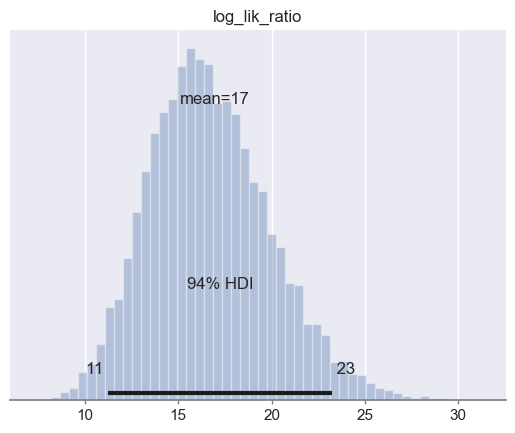

In [12]:
# plot log_lik_ratio posterior dist
az.plot_posterior(fit, var_names=["log_lik_ratio"], kind='hist', bins=50)

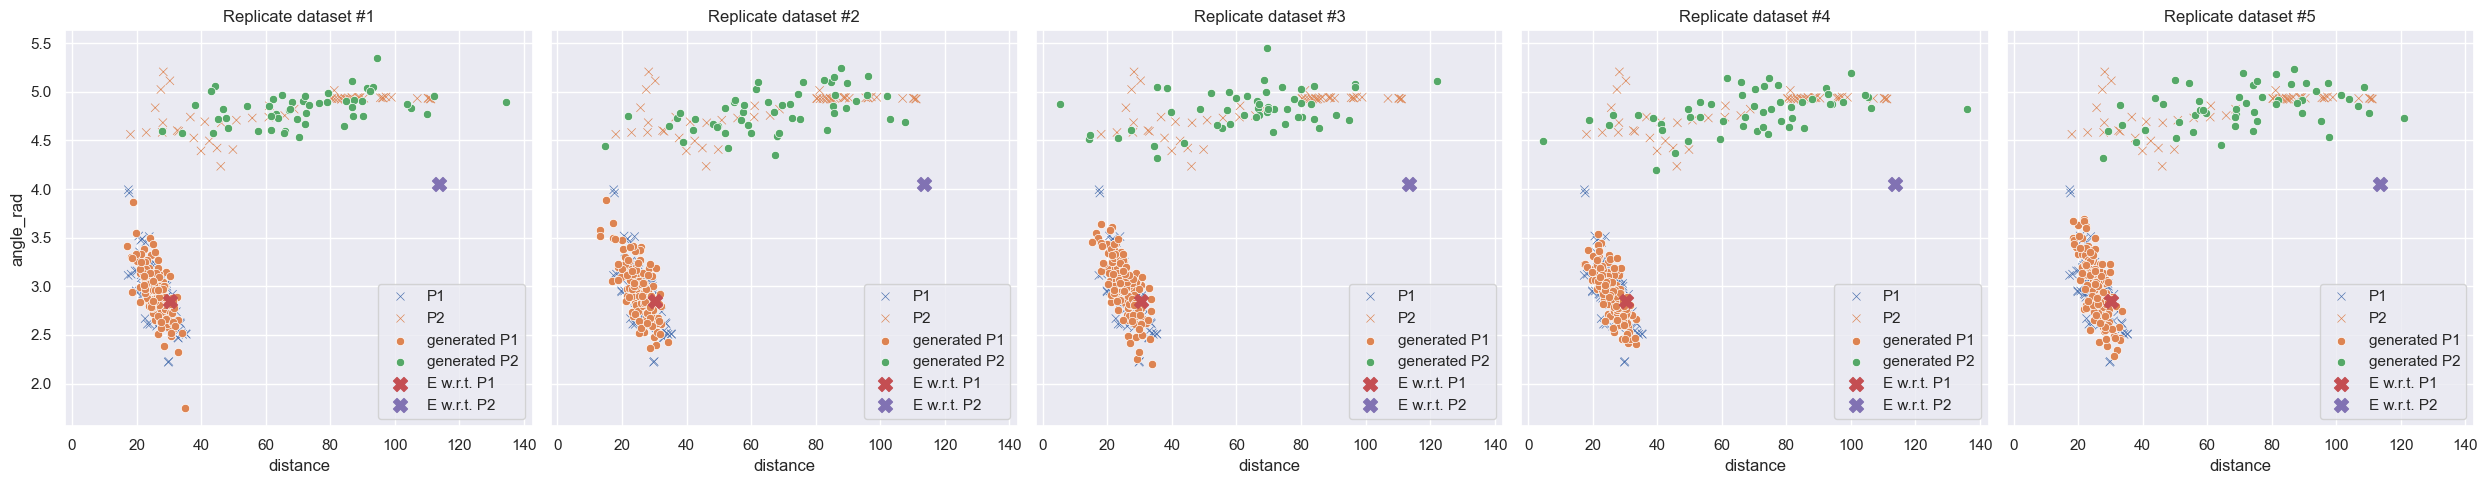

In [16]:
# plot the posterior predictive
# TODO: sort out the colors
fig, ax = plt.subplots(1, n_replicates, figsize=(n_replicates * 5, 5), sharex=True, sharey=True)
for i in range(n_replicates):
    sns.scatterplot(data=transformed_df, x='distance', y='angle_rad', hue='measured_from', ax=ax[i], marker='x')
    sns.scatterplot(data=pd.DataFrame(replicate_datasets_p1[i], columns=["distance", "angle_rad"]), x='distance', y='angle_rad', ax=ax[i], label="generated P1")
    sns.scatterplot(data=pd.DataFrame(replicate_datasets_p2[i], columns=["distance", "angle_rad"]), x='distance', y='angle_rad', ax=ax[i], label="generated P2")
    ax[i].scatter(E_P1_dist, E_P1_angle_rad, label="E w.r.t. P1", marker='X', s=100)
    ax[i].scatter(E_P2_dist, E_P2_angle_rad, label="E w.r.t. P2", marker='X', s=100)
    ax[i].set_title(f"Replicate dataset #{i + 1}")
    ax[i].set_xlabel("distance")
    ax[i].set_ylabel("angle_rad")
    ax[i].legend()

plt.tight_layout()  


array([[<Axes: title={'center': 'mu1\n0'}>,
        <Axes: title={'center': 'mu1\n1'}>,
        <Axes: title={'center': 'mu2\n0'}>],
       [<Axes: title={'center': 'mu2\n1'}>,
        <Axes: title={'center': 'sigma1\n0'}>,
        <Axes: title={'center': 'sigma1\n1'}>],
       [<Axes: title={'center': 'sigma2\n0'}>,
        <Axes: title={'center': 'sigma2\n1'}>,
        <Axes: title={'center': 'log_lik_ratio'}>]], dtype=object)

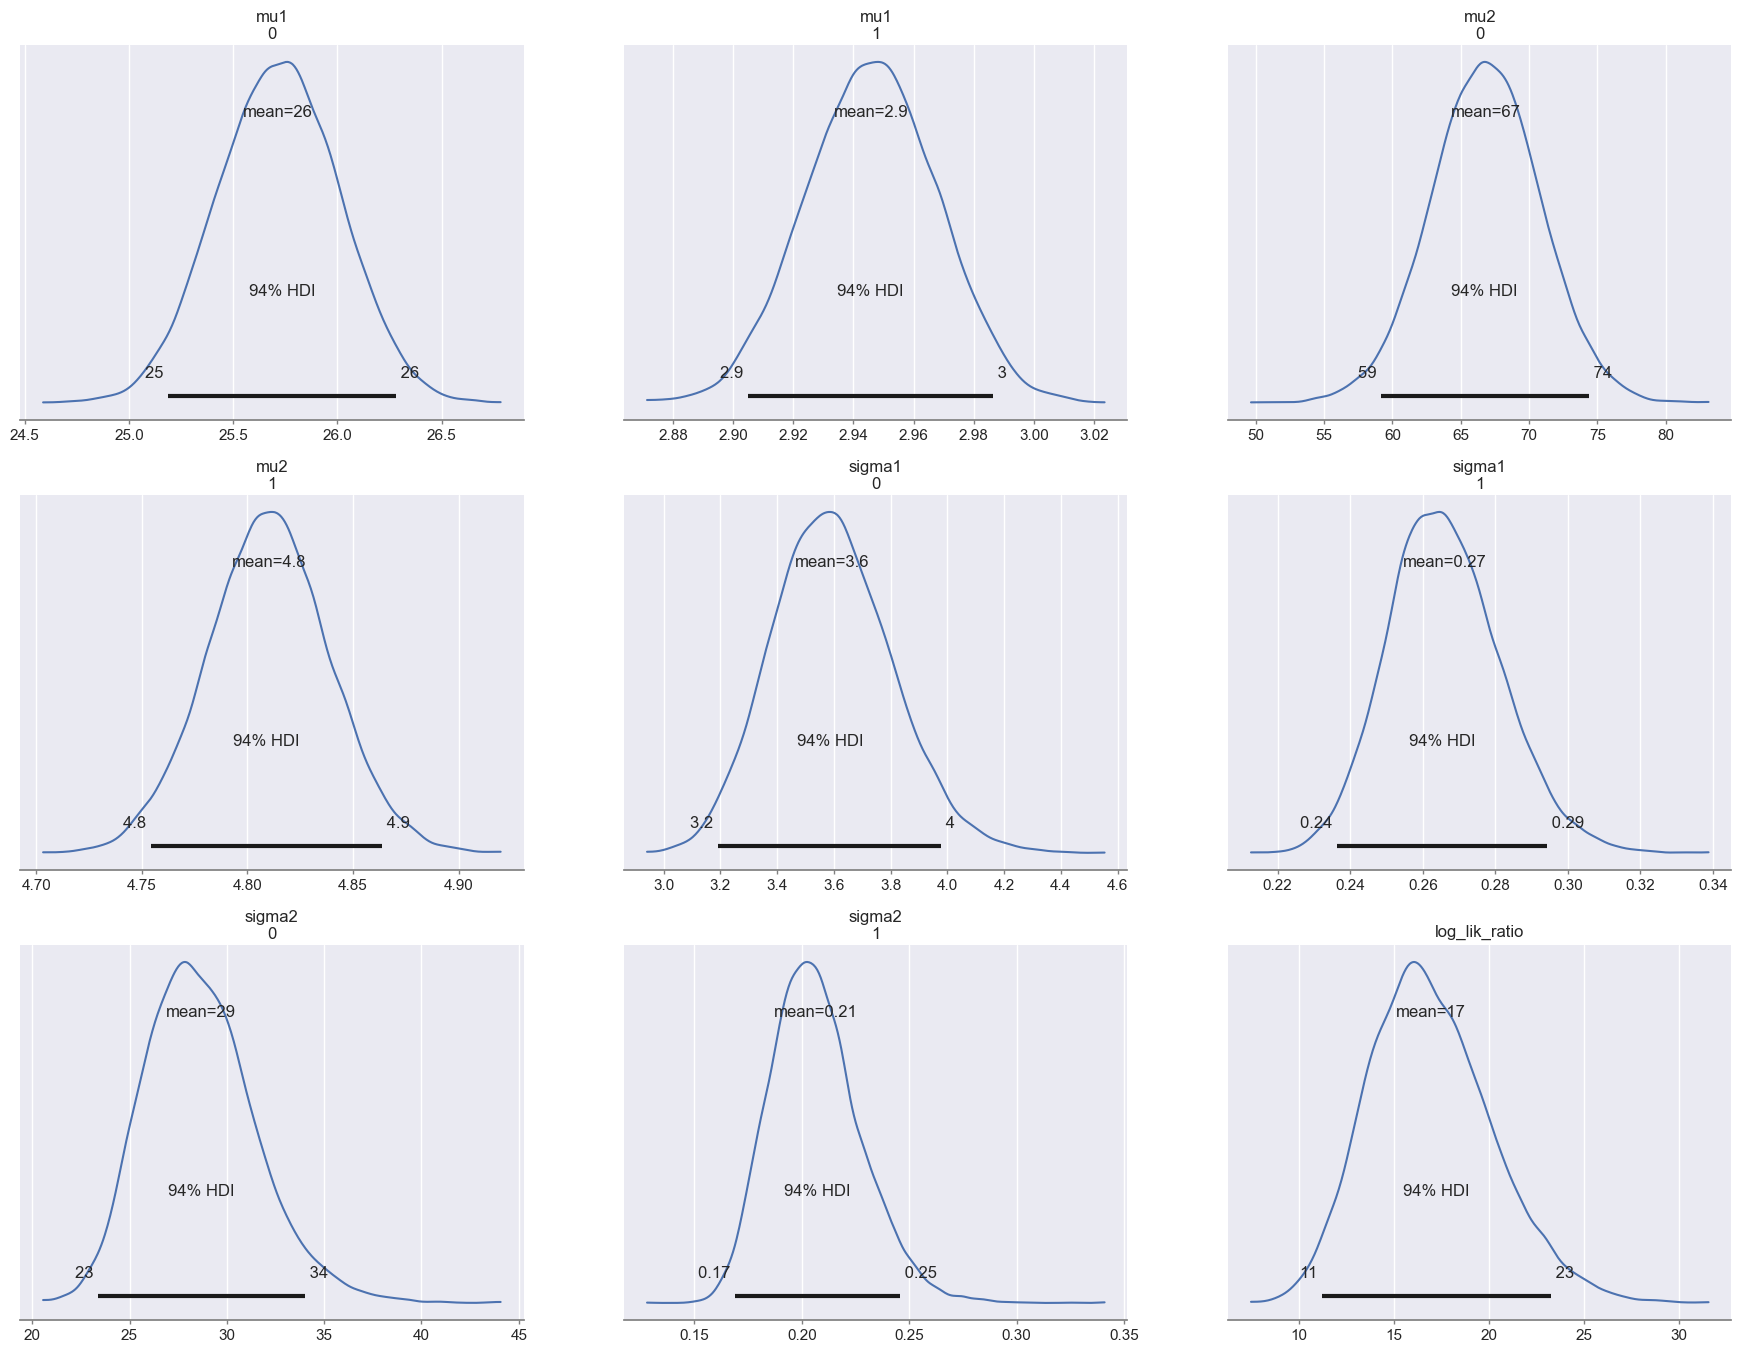

In [17]:
az.plot_posterior(fit, var_names=["mu1", "mu2", "sigma1", "sigma2", "log_lik_ratio"])


log likelihood ratio trace
Covariance matrix trace for P1)
Covariance matrix trace for P2)
Mean vector trace for P1)
Mean vector trace for P2)


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

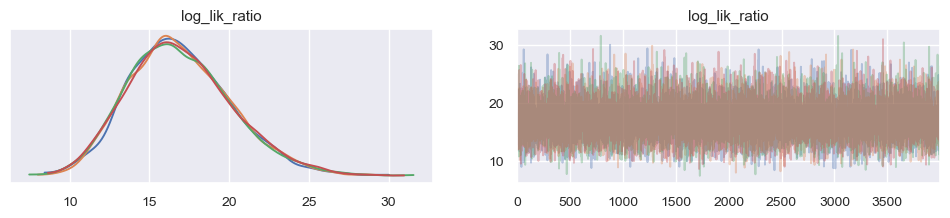

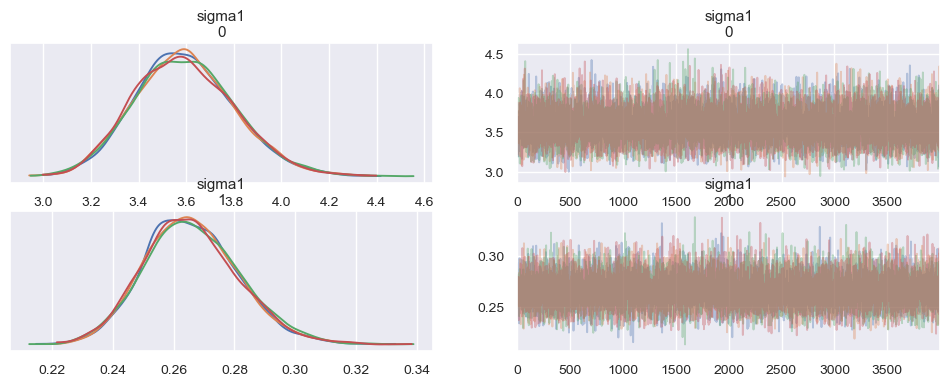

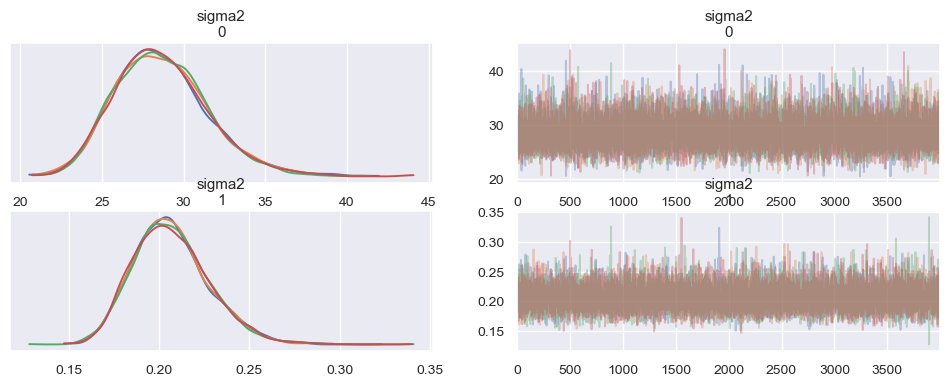

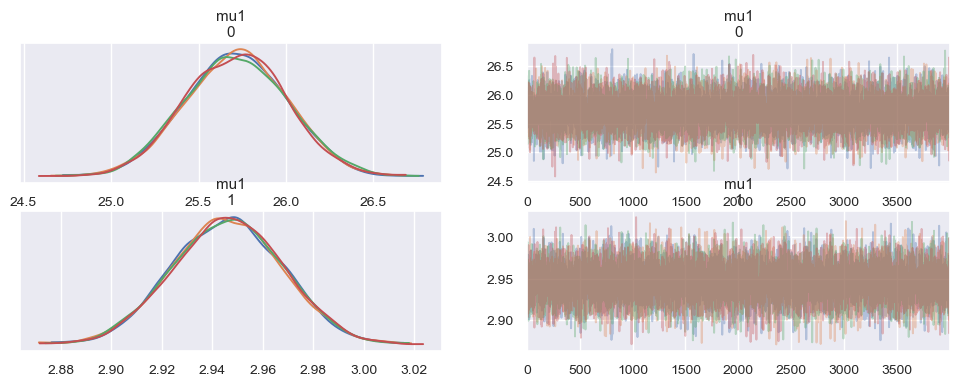

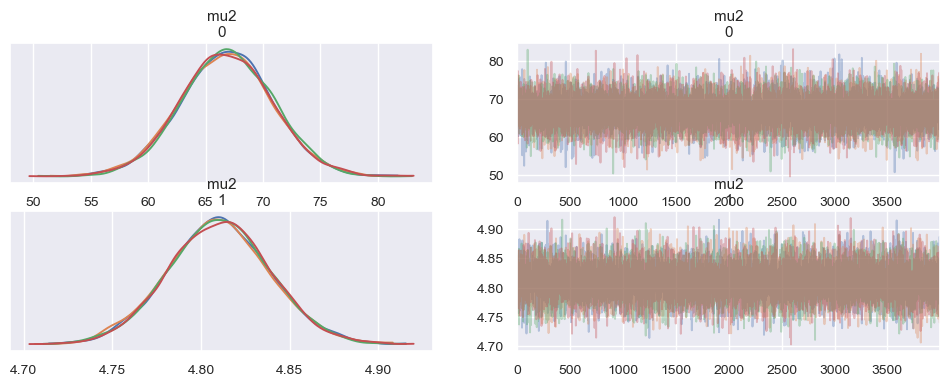

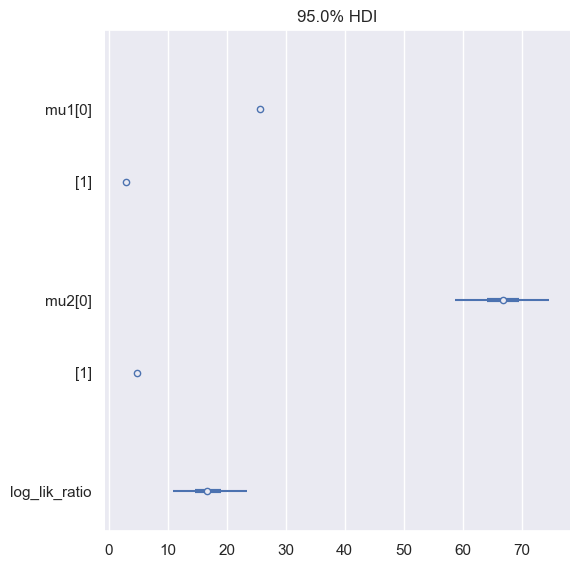

In [20]:
print("log likelihood ratio trace")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="log_lik_ratio")
print("Covariance matrix trace for P1)")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma1")
print("Covariance matrix trace for P2)")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma2")
print("Mean vector trace for P1)")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu1")
print("Mean vector trace for P2)")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu2")

az.plot_forest(fit, var_names=["mu1", "mu2", "log_lik_ratio"], combined=True, hdi_prob=0.95)



In [21]:
log_lik_ratio = fit.log_lik_ratio
# mean lr +- mcse
mean_lr = np.mean(log_lik_ratio)
mcse_lr = az.stats.mcse(log_lik_ratio)

print(f"Mean log likelihood ratio: {mean_lr} +- {mcse_lr}, 95% HDI: {az.hdi(log_lik_ratio, hdi_prob=0.95)}")

Mean log likelihood ratio: 16.930429961250002 +- 0.018249232114832287, 95% HDI: [10.8725 23.4078]
